## Intro
### Note on workflow:

This project was done with a Kaggle notebook, in multiple sessions. Data was downloaded either as a pickle or a model between runs. Once the runs were done and exported, I commented out the lines that created the data. If you would like to completly duplicate my work, those lines would have to be uncomemnted out.

I then added these pickles and models to a Kaggle dataset, which I copied in the working directory at the begining of each session. The data files are also avaliable on Github at https://github.com/highdeltav/DeepLearningWeek4.

### Libraries and helper functions

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model, save_model, clone_model


import os
from time import perf_counter
import pickle

from keras.layers import SimpleRNNCell
from keras.layers import GRUCell 
from keras.layers import LSTMCell 


from matplotlib import pyplot as plt
from seaborn import histplot
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
class Model:
    def __init__(self, X_train, y_train,X_val,y_val, model, name = 'Model'):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        #with tpu_strategy.scope():
        self.model = model
        self.name = name
        self.lr = 0.001
        self.stats = {self.name: {'history': {'loss': [],
                     'accuracy': [],
                     'val_loss': [],
                     'val_accuracy': []}, 'runtime':0, 'epochs':[], 'learning_rate':0}}

    def fit(self, epochs, batch_size = None):
        ''' Calls the fit function for the model and logs performance and saves history'''
        
       
        
        st = perf_counter()
        history = self.model.fit(x = self.X_train, y = self.y_train, validation_data = (self.X_val, self.y_val), epochs=epochs, batch_size = batch_size)
        et = perf_counter()
        runtime = et-st
        self.combine_stats(history, epochs, runtime)
        
    def show_accuracy_chart(self):
        '''Show a chart of the accuracy of the model '''
        train_acc =  self.history['accuracy']
        val_acc = self.history['val_accuracy']
        fig, ax = plt.subplots()
        ax.plot(range(self.epochs), train_acc, label = 'Training')
        ax.plot(range(self.epochs), val_acc,   label = 'Validation')
        ax.set_ylim([.5, 1])
        plt.title(f"{self.name}")
        ax.legend()
    
        plt.show()
    def summary(self):
        """Summary of the model"""
        self.model.summary()
        
    def compile(self, *args, **kwargs):
        '''Compiles the models, and just passes arguements through'''
        #with tpu_strategy.scope():
        self.model.compile(*args, **kwargs)
    def combine_stats(self,history, epochs, runtime):
        """
        When a new run is made on a model, combines the history information with the old one
        """
        current_epochs = len(self.stats[self.name]['epochs'])
        
        self.stats[self.name]['history']['loss'] += history.history['loss']
        self.stats[self.name]['history']['accuracy'] += history.history['accuracy']
        self.stats[self.name]['history']['val_loss'] += history.history['val_loss']
        self.stats[self.name]['history']['val_accuracy'] += history.history['val_accuracy']
        self.stats[self.name]['runtime'] += runtime
        self.stats[self.name]['epochs'] = list(range(1,current_epochs+epochs+1))
    
    def rename(self, new_name):
        self.stats[new_name] = self.stats.pop(self.name)
        self.name = new_name
        
    def predict(self, X):
        """
        Pass values to the model to make predictions
        """
        
        # Make predictions
        pred = self.model.predict(X)
        
        #Convert the predictions into 1s and 0s for the final predictions
        y_pred = []
        for prediction in pred:
            if prediction >= 0:
                y_pred.append(1)
            else:
                y_pred.append(0)
                
        return y_pred


In [3]:
def loop_models(train_data, val_data, model_list, epochs, lr = 0.001, sum_only = False):
    '''
    Takes a list of models and a dictionary, creates the models and saves them to the dictionary. 
    Each list should have a name of the model, followed by a list of the parameters for the architecture
    '''
    d = {}
    for i, params in enumerate(model_list):
        #Make sure that the same inital weights are used-
        tf.keras.backend.clear_session()
        tf.random.set_seed(846)
        
        print(f'Model: {params[0]}')
        
        tmp_model = build_model(*args, **kwargs)
        if sum_only == False:
            tmp_model.fit(epochs)
            d[params[0]] = tmp_model
        else:
            print(tmp_model.summary())
    return d
def build_model(params, train_data, val_data, model_list, epochs, lr, sum_only = False):
    '''
    Builds a model, and allows a learning rate to be set
    '''
    tmp_model = Model(train_data, val_data, Sequential(params[1]), name = params[0])
    tmp_model.lr = lr
    tmp_model.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=['accuracy'])
    return tmp_model

    

def plot_all_plots(d, plot_type = 'accuracy'):
    """Plot stats of all histories in a dictionary on a single chart"""
    
    total_plots = len(d)
    rows = int(np.ceil(total_plots/3))
    plt.figure(figsize = (15,5*rows))
    

    # Postion differently depending on amount of rows
    title_y = .98
    if rows >= 3:
        title_y = .9
    elif rows == 2:
        title_y = .93
    #Set the amount of columns
    cols = 3
    if total_plots < 3:
        cols = total_plots    
    
   
    for i, model in enumerate(d):
        
         #Check to see which variables to plot
        if plot_type == 'accuracy':
            y_axis_train = d[model]['history']['accuracy']
            y_axis_val = d[model]['history']['val_accuracy']
            title = 'Accuracy'
            y_limit = [.5,1]
        elif plot_type == 'loss':
            y_axis_train = d[model]['history']['loss']
            y_axis_val = d[model]['history']['val_loss']
            title = 'Loss'
            y_limit = [0,1.5]
        else:
            print('Avaliable options are: Loss and Accuracy')
            return
        plt.subplot(rows, cols, i+1)
        plt.plot(d[model]['epochs'], y_axis_train, label = 'Training')
        plt.plot(d[model]['epochs'], y_axis_val,   label = 'Validation')
        plt.ylim(y_limit)
        plt.title(f"{model}")
        plt.xlabel('Epochs')
        plt.ylabel(title)

        plt.legend()

    plt.suptitle(title, fontsize=20, y = title_y)
    plt.show()     
    
def pickle_out(filename, object):
    """Write an object out to the directory /pickles"""
    filename = filename
    pickling_on = open(filename, "wb")
    pickle.dump(object, pickling_on)
    pickling_on.close()

def save_loop_info(prefix, d):
    """
    Saves a dictionary with the history, and other run information for the loop function
    """
    
    #model_dict
    save_histories = {}
    # Export the models
    for each in d:
        #print(each)
        d[each].model.save(f"{prefix}_{each}.tf")
        
        #Export a dictionary witht he history information
        save_histories[each] = {'history': d[each].history, 'runtime':d[each].runtime, 'epochs':d[each].epochs, 'learning_rate':d[each].lr}
        #save_histories[each] = save_model_info(d[each])
    pickle_out(f'{prefix}.pickle', save_histories)

def combine_dictionarys (d_list, new_name):
    
    new_loss = []
    new_accuracy = []
    new_val_loss = []
    new_val_accuracy = []
    new_runtime = 0
    new_epochs = 0
    lr = 0
    
    #Loop through dictionaries and add them
    for i in d_list:
        #for j in i:
        new_loss += i['history']['loss']
        #print(i[j]['history']['loss'])
        new_accuracy += i['history']['accuracy']
        new_val_loss += i['history']['val_loss']
        new_val_accuracy += i['history']['val_accuracy']
        new_runtime += i['runtime']
        new_epochs += i['epochs']
        lr = i[j]['learning_rate']
    new_d = {}
    new_d[new_name] = {'history': {'loss': new_loss, 'accuracy': new_accuracy, 'val_loss': new_val_loss, 'val_accuracy':new_val_accuracy},
                       'runtime' : new_runtime, 'epochs':new_epochs, 'learning_rate': lr}
    return new_d

def create_summary_table(d):
    """Creates a summary table from a dictionary"""

    max_acc = []
    min_loss = []
    max_val_acc = []
    epoch_min_val_loss = []
    min_val_loss = []
    row_names = []
    runtime = []
    for each in d:
        max_acc.append(max(d[each]['history']['accuracy']))
        min_loss.append( min(d[each]['history']['loss']))
        max_val_acc.append(max(d[each]['history']['val_accuracy']))
        min_val_loss.append(min(d[each]['history']['val_loss']))
        epoch_min_val_loss.append(np.argmin(d[each]['history']['val_loss']))
        row_names.append(each)
        runtime.append(d[each]['runtime'])
    df = pd.DataFrame(list(zip(row_names, max_acc,min_loss, max_val_acc, min_val_loss, epoch_min_val_loss)),
                     columns = ['Model','Max Acc', 'Minnimum Loss','Max Val Acc','Min Val Loss','Epoch of Min Val Loss']).round(3)
    display(df)


In [4]:
def plot_models_together(d):
    '''
    Plots all of the metircs curves on 4 plots in 1 figure
    '''
    
    
        
    fig, axes = plt.subplots(2,2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    #ax.plot(range(self.epochs), val_acc,   label = 'Validation')
    plot_types = ['accuracy','val_accuracy','loss','val_loss']
    for p in plot_types:
        if p == 'val_accuracy':
            ylab = 'Accuracy'
            title = 'Validation Accuracy'
            lim = [.5,1]
            ax = axes[0,0]
        elif p == 'accuracy':
            ylab = 'Accuracy'
            title = 'Training Accuracy'
            lim = [.5,1]
            ax = axes[0,1]
        elif p =='val_loss':
            ylab = 'Loss'
            title = 'Validation Loss'
            lim = [0,1.5]
            ax = axes[1,0]
        elif p == 'loss':
            ylab = 'Loss'
            title = 'Training Loss'
            lim = [0,1.5]
            ax = axes[1,1]
        #Add data from all of the models
        for model in d:
            train_acc = (d[model]['history'][p])
            ax.plot(d[model]['epochs'], train_acc, label = model)
        
        ax.set_ylim(lim)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylab)
        ax.set_title(title)
        ax.legend()
    plt.show()
    

In [5]:
# Copy all saved input files to the Kaggle working directory
cwd = os.getcwd()
os.popen(f'cp /kaggle/input/deep-learning-week4/* {cwd}')
os.listdir(cwd)

['run6.pickle',
 'run4.pickle',
 'kaggle_predictions1.csv',
 'state.db',
 'final.pickle',
 '__notebook_source__.ipynb',
 'run5.pickle',
 '.virtual_documents',
 'run1.pickle',
 'X_train_augmented.pickle',
 'run2.pickle',
 'run3.pickle']

# Data
## Description
This is a Kaggle dataset of tweets, where some of the tweets have reference to a real disaster and some of them do not. The goal of this project is to create a model that can differentiate between the two different types of tweets. There are 7613 data points in the training data set. There are three features in the dataset, "text," "location," and 'keyword' and a ‘target’ value  of zero or one that shows if the tweet was talking about a real disaster. Forty-three percent of then are positive for a real disaster, and Fifty-seven percent of them do not contain reference to disasters. This is a natural language processing (NLP) problem. There are many different ways to tackle a NLP problem. For this specific project I am going to be using recurrent neural networks. 

In [10]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

## EDA
I did some basic EDA on the dataset to make sure that we didn't need to do any work before creating our model. The first thing that I did was verify that it did not have any missing values, and also verify that all of the target values were either a one of a zero. I also wanted to make sure that the dataset is not unbalanced, because that does not work well for training. They are split up 57 percent do not have a disaster, and 43 percent of them do. That is not too unbalanced for our purposes. 

The last thing I did was create a function that would randomly show me pieces of the dataset, so I could see what kind of data I was working with. It surprised when I saw several tweets that were miscategorized. For example:
*'Index: 5497 Text: Reddit Will Now Quarantine Offensive Content http://t.co/LTmgdP6Jaf, Target: 1'.*

This is obviously not talking about a quarantine as a result of a disaster, so it should have had a target of zero. While we can still train on this model, it brings into question the veracity of the entire project.

In [8]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [9]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# Verify there are no null values
print(f"Null values in text: {len(train[train['text'].isnull()])}")
print(f"Null values in target: {len(train[train['target'].isnull()])}")
print(f"Target values not equal to '0' or '1': {len(train[~train['target'].isin([1,0])])}")


Null values in text: 0
Null values in target: 0
Target values not equal to '0' or '1': 0


In [11]:
# Proportion of target values
print(f"Percent of values that are positive: {(np.count_nonzero(train['target'])/len(train)*100):.2f}%")
print(f"Percent of values that are positive: {((len(train)-np.count_nonzero(train['target']))/len(train)*100):.2f}%")


Percent of values that are positive: 42.97%
Percent of values that are positive: 57.03%


In [11]:
# Randomly display 10 tweets
t = np.array(train['text'])
t1 = np.array(train['target'])
rand_list = np.random.randint(0,7613, 10)
for a in rand_list:
    print(f"Index: {a} Text: {t[a]}, Target: {t1[a]}")
    

Index: 6772 Text: I feel like a tornado http://t.co/iZJK6kpWiZ, Target: 1
Index: 260 Text: The annihilation of Jeb Christie &amp; Kasich is less than 24 hours away..
Please God allow me at least one more full day..., Target: 0
Index: 3934 Text: Flood Advisory in effect for Shelby County in AL until 9 PM #alwx http://t.co/gTqMGsgcsB, Target: 1
Index: 7338 Text: California is battling its scariest 2015 wildfire so far. http://t.co/Lec1vmS7x2, Target: 1
Index: 5361 Text: The cool kids asked me if I wanted to hang out after school so I had a panic attack and had to go to the hospital #autismawareness, Target: 0
Index: 3426 Text: Learn How I Gained Access To The Secrets Of The Top Earners &amp; Used Them To Explode My Home Business Here: http://t.co/e84IFMCczN Please #RT, Target: 0
Index: 857 Text: people with a #tattoo out there.. Are u allowed to donate blood and receive blood as well or not?, Target: 1
Index: 2287 Text: Think Akwa Ibom!: DonÛªt come to Uruan and demolish buildings again

In [12]:
# Show miscatagorized tweet
print(f"Index: {5497} Text: {t[5497]}, Target: {t1[5497]}")
print(f"Index: {6772} Text: {t[6772]}, Target: {t1[6772]}")

Index: 5497 Text: Reddit Will Now Quarantine Offensive Content http://t.co/LTmgdP6Jaf, Target: 1
Index: 6772 Text: I feel like a tornado http://t.co/iZJK6kpWiZ, Target: 1


In [14]:
list_len=[len(tweet) for tweet in train['text']]
print(max(list_len))

157


<Axes: xlabel='target', ylabel='Count'>

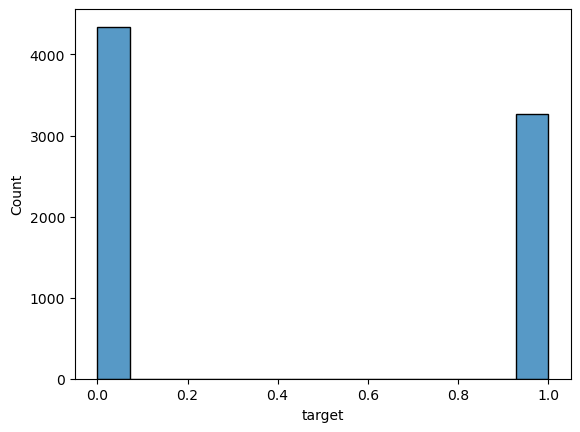

In [15]:
histplot(train['target'])

## Pre-processing
### Inital
Before we could start the model, we did have to pre-process the data. Since this is a project for NLP with an RNN, I removed the columns keyword and location, and chose not to train on those columns, since they weren’t part of the text of the tweet.. I also split the data into a train and validation section. I used 66 percent from training and 33 percent for the validation dataset.

In [16]:
# Split the Data
X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.33, random_state=42)

### Data Augmentation
Another aspect of preprocessing that I did was I created a second dataset where I augmented the data. I used the plugin nlpaug and added to the training set tweets that had the same tweets where all of the words were replaced by synonyms. This should allow the dataset to be able to train on more words, and do better with the validation and test data. I will begin by training on the data without the augmentation, and then train on the data with it to see how much of a difference it makes in this use case.
### Note
This is the code that was run in another notebook, because it didn't play nice with Kaggle. If you want to run it, uncomment out the lines below. As it was, I ran it offline, and imported the augmented values.

In [17]:
#import nlpaug.augmenter.word as naw
#aug = naw.SynonymAug()
#X_train_augment= aug.augment(list(X_train))
#X_train_augment = pd.Series(X_train_augment)
#X_train_augmented = X_train.append(X_train_extra)
#pickle_out('X_train_augmented.pickle', X_train_augmented)

In [18]:
# Created a new training set that contains the augmented data
X_train_augmented = pd.read_pickle('X_train_augmented.pickle')
y_train_augmented = y_train.append(y_train)

/tmp/ipykernel_7462/1698677962.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train_augmented = y_train.append(y_train)


### Text Vectorization
In order to do any kind of NLP, we need to convert the text into a format that is machine readable. I used Keras's built-in text vectorization tool to accomplish this. First it standardizes the text by removing all punctuation and making everything lower case. In its most simplistic form, it then compiles a list of every single word that is found in the all of the tweets, and creates a vector of that length for every single tweet. It then has a number that shows the amount of each word in each tweet. That is the data that is then passed to the algorithm. There are more complicated variations on this concept such TF-IDF, that makes attempts to weight each separate document better to give more accurate results. For this project, I went with the more simplistic method.

I did this for both the original training set and the training set with the augmented data.

In [19]:
# Create the enocder for the text vectorizaton layer
number_of_words = 1000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=number_of_words)
encoder.adapt(list(train['text']))
word_count = len(encoder.get_vocabulary())


In [20]:
# Create the enocder for the augmented text vectorizaton layer 
encoder_aug = tf.keras.layers.TextVectorization(
    max_tokens=number_of_words)
encoder_aug.adapt(list(X_train_augmented))
word_count_aug = len(encoder_aug.get_vocabulary())

# Model Testing
## Architecture

As previously mentioned, I tackled this problem with RNN and networks that have been derived from basic RNN, such as Long Short Term Memory (LSTM) and  Gated Recurrent Units (GRU). One advantage that RNNs have is that they have ‘memory’ and can take into account how things were previously in a sequential dataset.  However, in standard RNN, there is a tendency for the gradients in the back propagation to either disappear or explode, which creates problems in trying to accurately reduce the loss. LTSM and GRU are attempts to make up for some of the shortcoming of RNN.   LSTM and GRU try and rectify this problem by creating gates that also carry memory information forward, but do it in a way that can be easily back propagated. 

There is also a concept of making the models bidirectional, where the model can go forward and backward through the  sequence. In theory, this should make the model more accurate, because it is less dependent on order that things happened. 

### Testing Procedure
I initially tested RNN, LSTM and GRU with both bidirectional, and non-bidirectional layers. I then took the architecture that had the best result, and used that to attempt to tune the model better.

In [21]:
### RNN without Bidirectional
tf.keras.backend.clear_session()
tf.random.set_seed(846)
rnn_1 = Model(X_train, y_train, X_val, y_val, name ='RNN without Bidirectional', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.SimpleRNN(64),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

rnn_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
rnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 148,801
Trainable params: 148,801
Non-trainable params: 0
__________________________________________________

In [22]:
# Uncomment to run the model
#rnn_1.fit(30)

### RNN with Bidirectional

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
rnn_2 = Model(X_train, y_train, X_val, y_val, name ='RNN with Bidirectional', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

rnn_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
rnn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              24704     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 169,345
Trainable params: 169,345
Non-trai

In [24]:
# Uncomment to run the model
#rnn_2.fit(30)

### LTSM without Bidirectioanl

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
ltsm_1 = Model(X_train, y_train, X_val, y_val, name ='LTSM without Bidirectional', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.LSTM(64,),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

ltsm_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
ltsm_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 185,857
Trainable params: 185,857
Non-trainable params: 0
__________________________________________________

In [26]:
# Uncomment to run the model
#ltsm_1.fit(30)

### LTSM with Bidirectional

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
ltsm_2 = Model(X_train, y_train, X_val, y_val, name ='LTSM with Bidirectional', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

ltsm_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
ltsm_2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 243,457
Trainable params: 243,457
Non-trai

In [28]:
# Uncomment to run the model
#ltsm_2.fit(30)

### GRU without Bidirectional

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
gru_1 = Model(X_train, y_train, X_val, y_val, name ='GRU without Bidirectional', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.GRU(64),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

gru_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 173,697
Trainable params: 173,697
Non-trainable params: 0
__________________________________________________

In [30]:
# Uncomment to run the model
#gru_1.fit(30)

### GRU with Bidirectional

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
gru_2 = Model(X_train, y_train, X_val, y_val, name ='GRU with Bidirectional', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

gru_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 219,137
Trainable params: 219,137
Non-trai

In [32]:
# Uncomment to run the model
#gru_2.fit(30)

In [33]:
#Combine all of the stats into one dictionarty and export. Uncomment to run notebook without saved data.
#run1_combined = rnn_1.stats | rnn_2.stats | ltsm_1.stats | ltsm_2.stats | gru_1.stats | gru_2.stats
#pickle_out('run1.pickle', run1_combined)

## Initial Testing Summary
After looking at all of the data, I decided to go with the GRU with a bidirectional layer. It was very similar to LSTM with a bidirectional layer, but I didn't have the time or resources to test both of them within the scope of this project, so I went with one which was the GRU, since it was a tossup between GRU and LSTM.

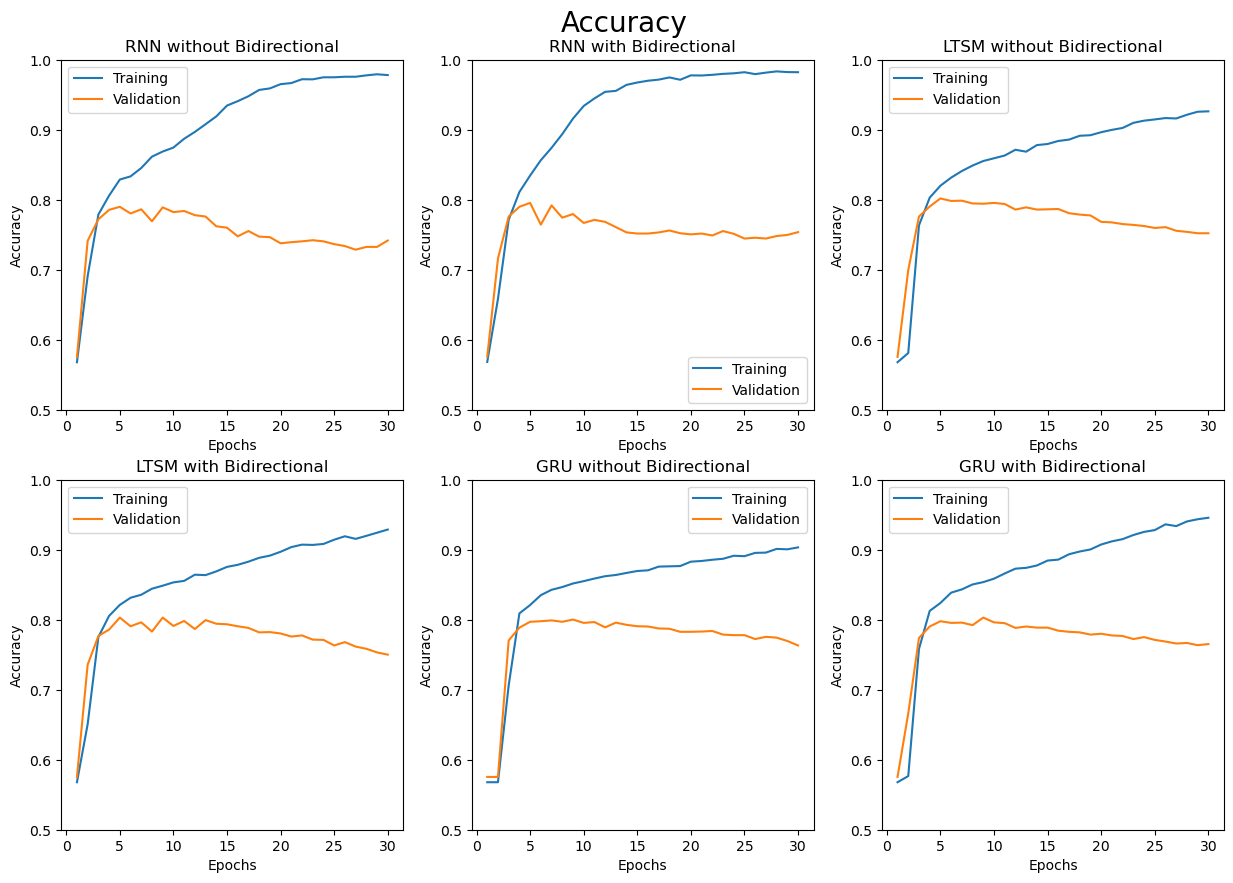

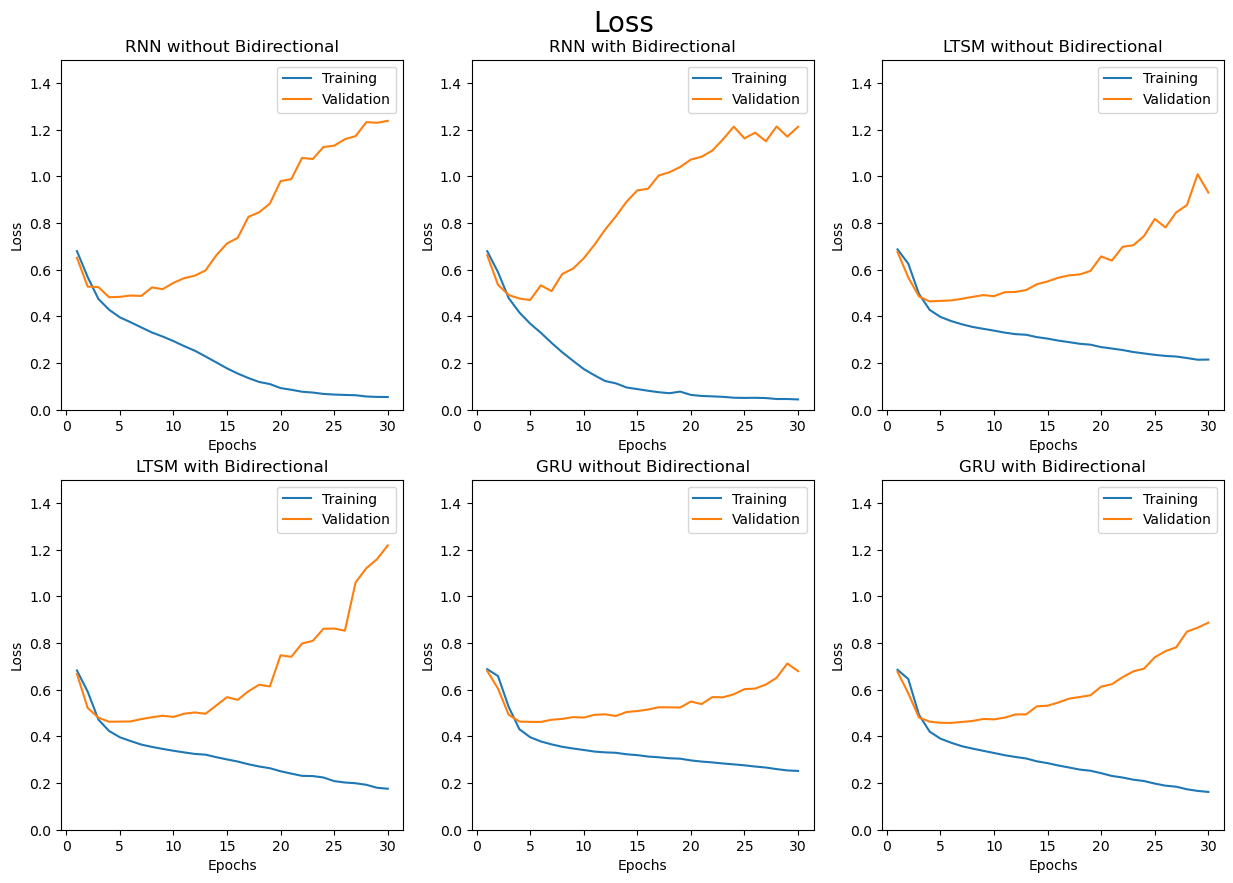

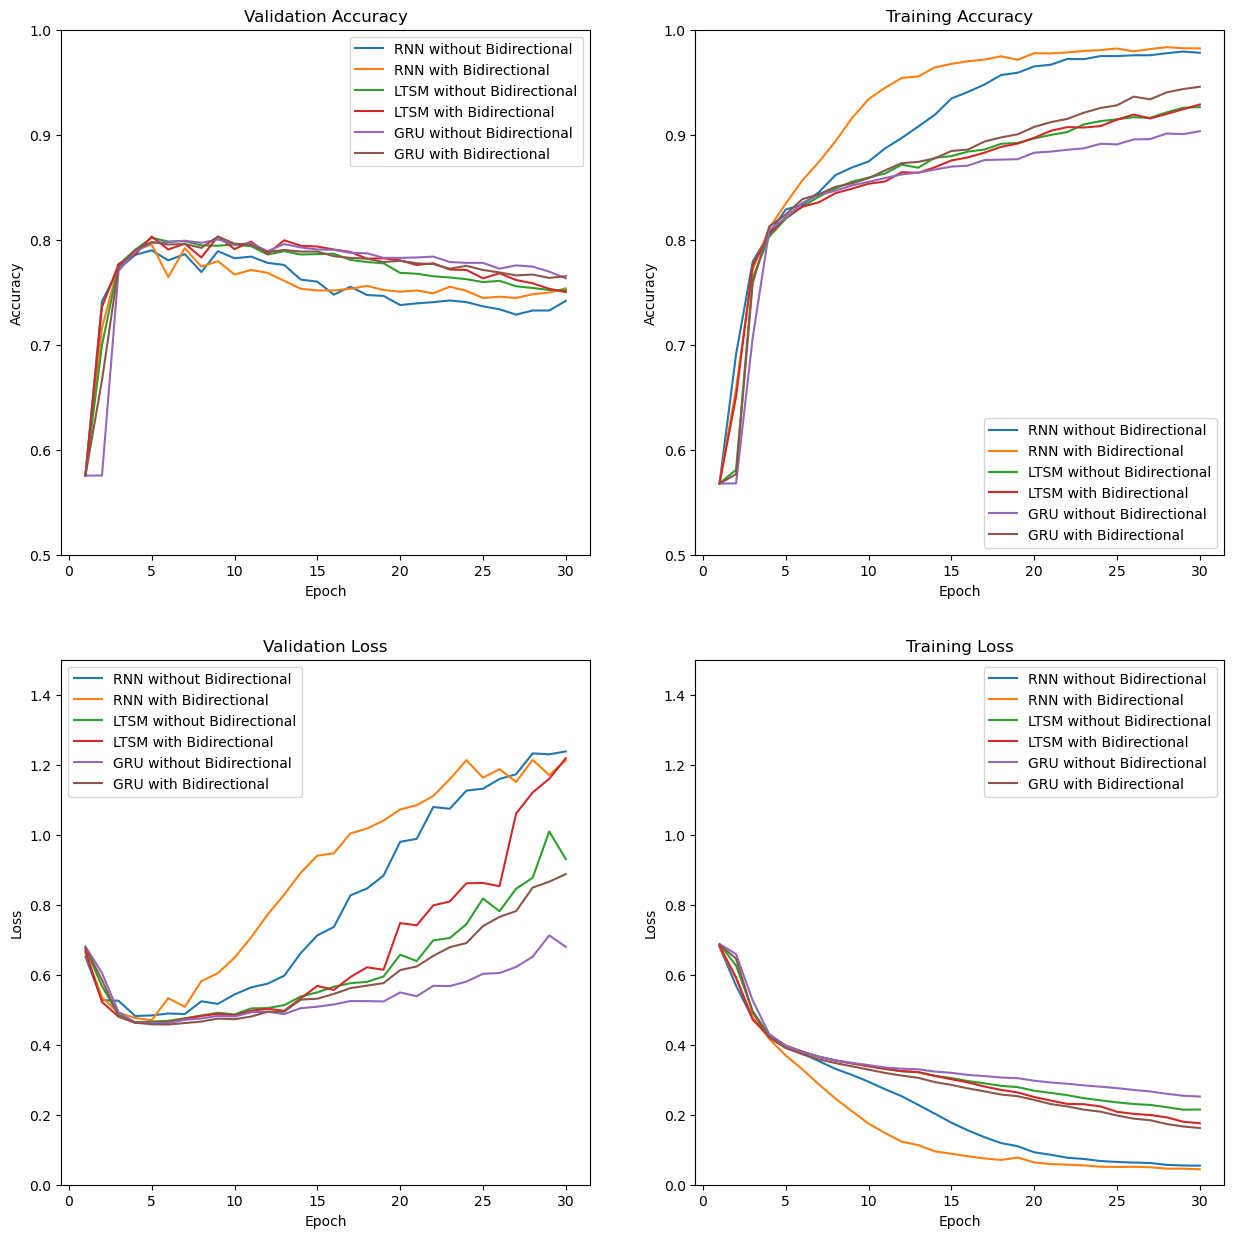

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,RNN without Bidirectional,0.979,0.054,0.790,0.482,3
1,RNN with Bidirectional,0.983,0.044,0.795,0.470,4
2,LTSM without Bidirectional,0.926,0.214,0.802,0.464,3
3,LTSM with Bidirectional,0.929,0.176,0.803,0.463,3
4,GRU without Bidirectional,0.903,0.252,0.800,0.462,5
5,GRU with Bidirectional,0.946,0.162,0.803,0.458,5


In [34]:
run1 = pd.read_pickle('run1.pickle')
plot_all_plots(run1, plot_type = 'accuracy')
plot_all_plots(run1, plot_type = 'loss')
plot_models_together(run1)
create_summary_table(run1)

## GRU Hyperparameter Changes
The next part of my plan was to test several aspects of the model in order to see if I could improve the results. The first thing I did was increase the number of  GRU units and see if that improved accuracy.

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
gru_hp_1 = Model(X_train, y_train, X_val, y_val, name ='Gru 64', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

gru_hp_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hp_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 219,137
Trainable params: 219,137
Non-trai

In [36]:
#gru_hp_1.fit(30)

In [37]:
#Change Gru layer to 128

tf.keras.backend.clear_session()
tf.random.set_seed(846)
gru_hp_2 = Model(X_train, y_train, X_val, y_val, name ='Gru 128', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(128)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

gru_hp_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hp_2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 359,169
Trainable params: 359,169
Non-trai

In [38]:
#gru_hp_2.fit(30)

In [39]:
#Gru layers 256
tf.keras.backend.clear_session()
tf.random.set_seed(846)
gru_hp_3 = Model(X_train, y_train, X_val, y_val, name ='Gru 256', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(256)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

gru_hp_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hp_3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 512)              592896    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 786,689
Trainable params: 786,689
Non-trai

In [40]:
#gru_hp_3.fit(30)

In [41]:
#Combine all of the stats into one dictionarty and export
#run2 = gru_hp_1.stats | gru_hp_2.stats | gru_hp_3.stats
#pickle_out('run2.pickle', run2)


## GRU Units Conclusion
After testing the amount of GRU units, I found no real improvment in accuracy, but it did increase the runtime, so I am going to stick with the 64 units for any remaining tests.

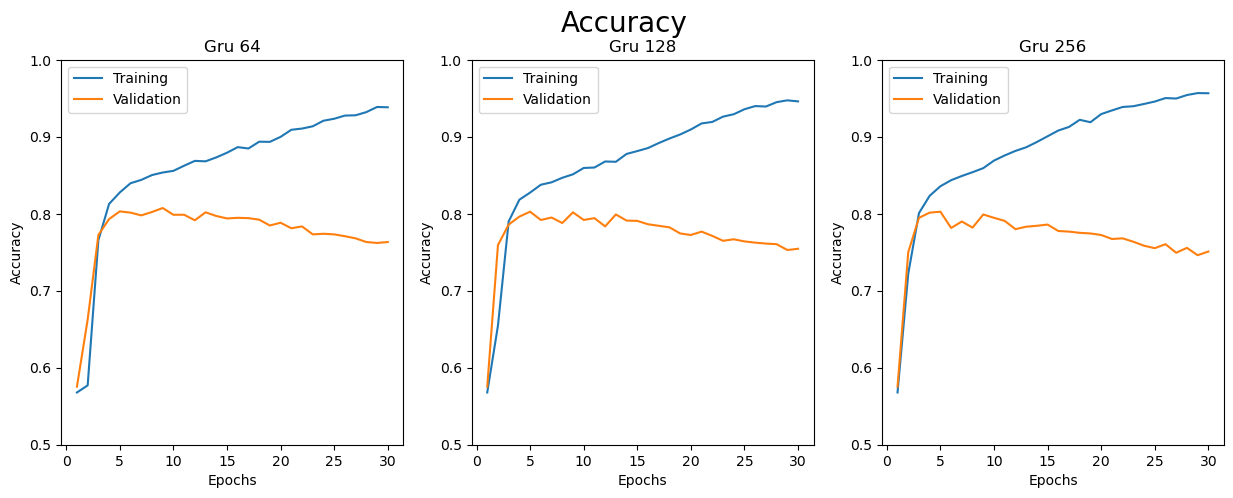

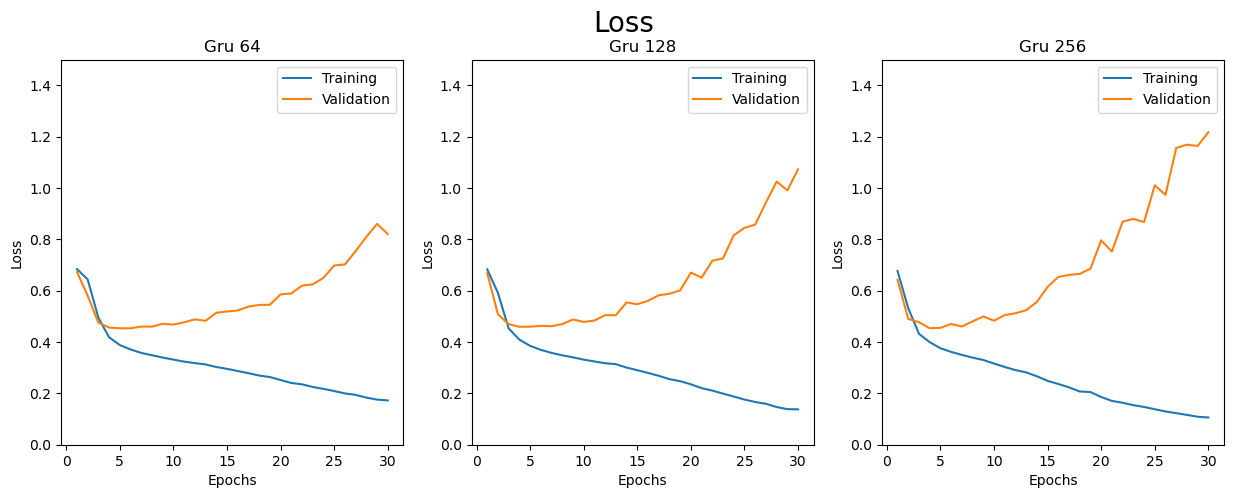

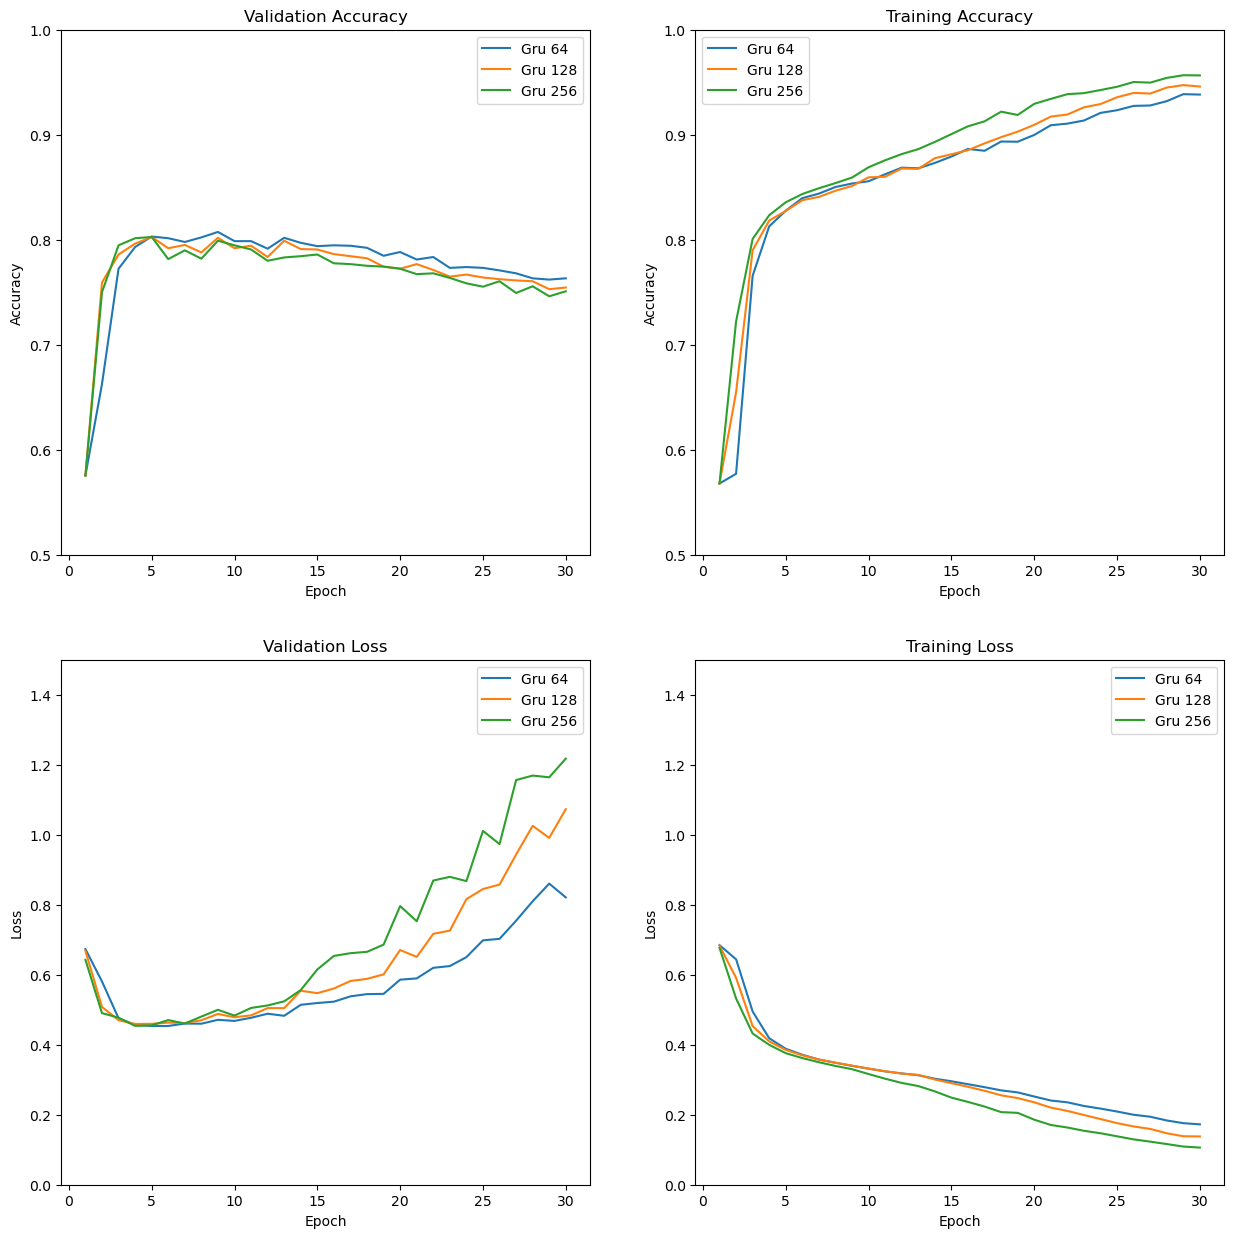

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,Gru 64,0.939,0.173,0.807,0.454,4
1,Gru 128,0.947,0.138,0.803,0.459,3
2,Gru 256,0.957,0.106,0.803,0.454,3


In [43]:
run2 = pd.read_pickle('run2.pickle')
plot_all_plots(run2, plot_type = 'accuracy')
plot_all_plots(run2, plot_type = 'loss')
plot_models_together(run2)
create_summary_table(run2)

## Change embedding layer size
My next change that I experimented with was changing embedding layer size. This layer changes all of the tweets into a layer of the same size. By increasing this number, I was hoping to be able to increase the resolution of the neural network, and get a more accurate result.

In [44]:
# Embed 128

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
 #   model = tf.keras.Sequential( … ) # define your model normally
  #  model.compile( … )

# train model normally



#tf.keras.backend.clear_session()
tf.random.set_seed(846)

gru_hpb_1 = Model(X_train, y_train, X_val, y_val, name ='Embed 128', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_hpb_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hpb_1.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 219,137
Trainable params: 219,137
Non-tr

In [45]:
#Uncomment to run model
#gru_hpb_1.fit(30)

In [46]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
gru_hpb_2 = Model(X_train, y_train, X_val, y_val, name ='Embed 256', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=256,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

gru_hpb_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hpb_2.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              123648    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 396,289
Trainable params: 396,289
Non-trai

In [47]:
#Uncomment to run model
#gru_hpb_2.fit(30)

In [48]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
gru_hpb_3 = Model(X_train, y_train, X_val, y_val, name ='Embed 512', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=512,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

gru_hpb_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hpb_3.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 512)         512000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              221952    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 750,593
Trainable params: 750,593
Non-trai

In [49]:
#Uncomment to run model
#gru_hpb_3.fit(30)

In [50]:
tf.keras.backend.clear_session()
tf.random.set_seed(846)
gru_hpb_4 = Model(X_train, y_train, X_val, y_val, name ='Embed 64', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=64,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

gru_hpb_4.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hpb_4.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 130,561
Trainable params: 130,561
Non-trai

In [51]:
#Uncomment to run model
#gru_hpb_4.fit(30)

In [52]:
#Combine all of the stats into one dictionarty and export
#run3 =  gru_hpb_4.stats | gru_hpb_1.stats | gru_hpb_2.stats | gru_hpb_3.stats
#pickle_out('run3.pickle', run3)

## Embedding layer summary
After looking at the data, there is no benefit to increasing the size of the embedded layer, so I tried one layer that was smaller than the 128 dimensions I initially started with. It was very similar to the 128, so I decided to stick with 128 as to not induce a variable change, with very little, if any, discernible value.

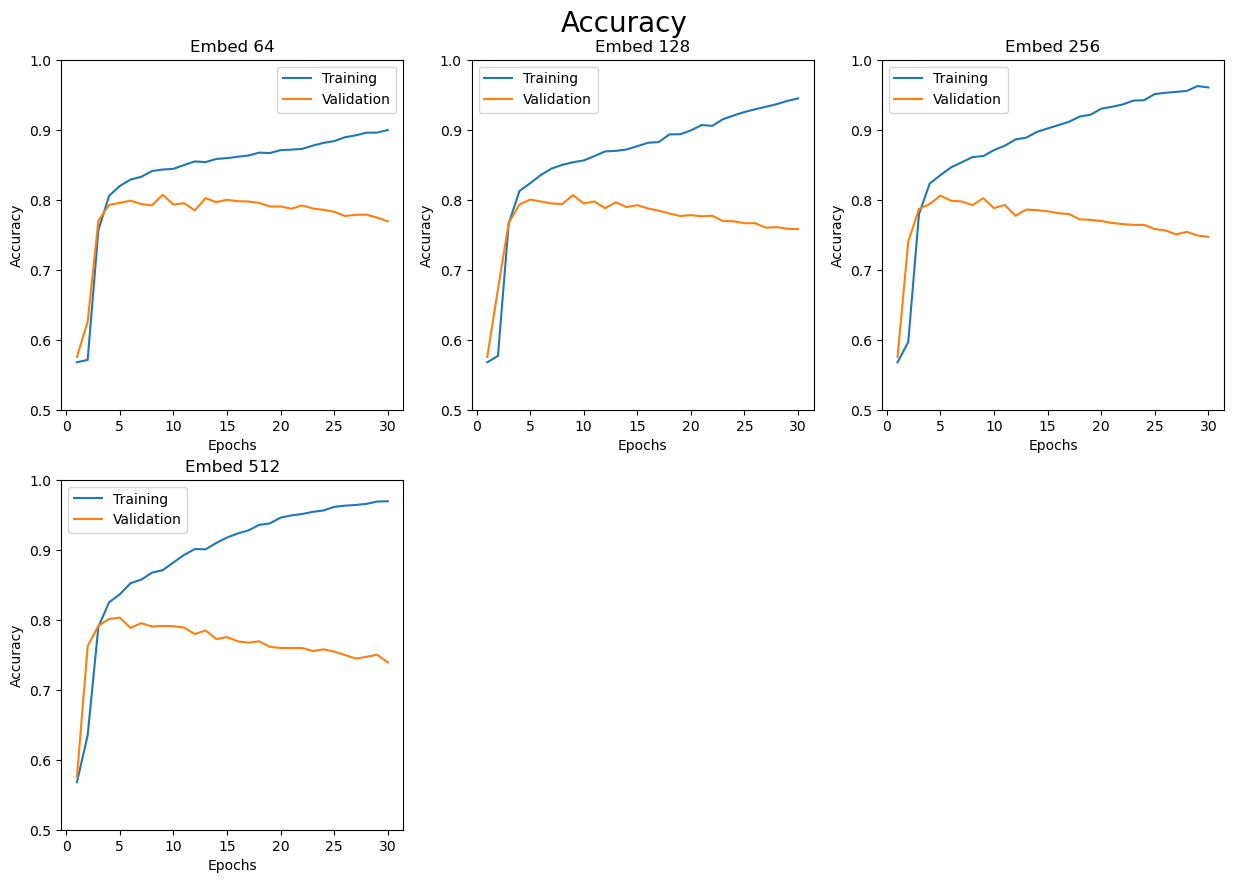

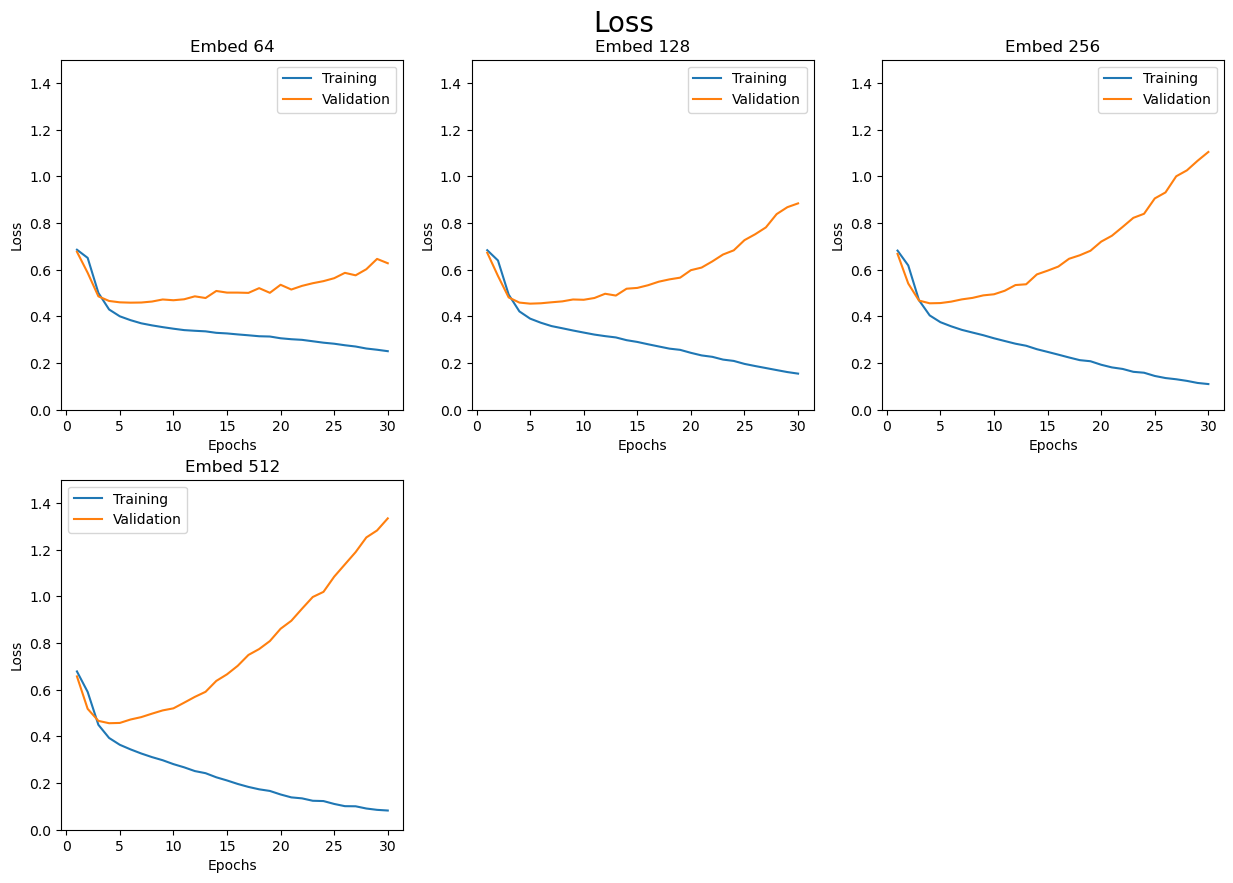

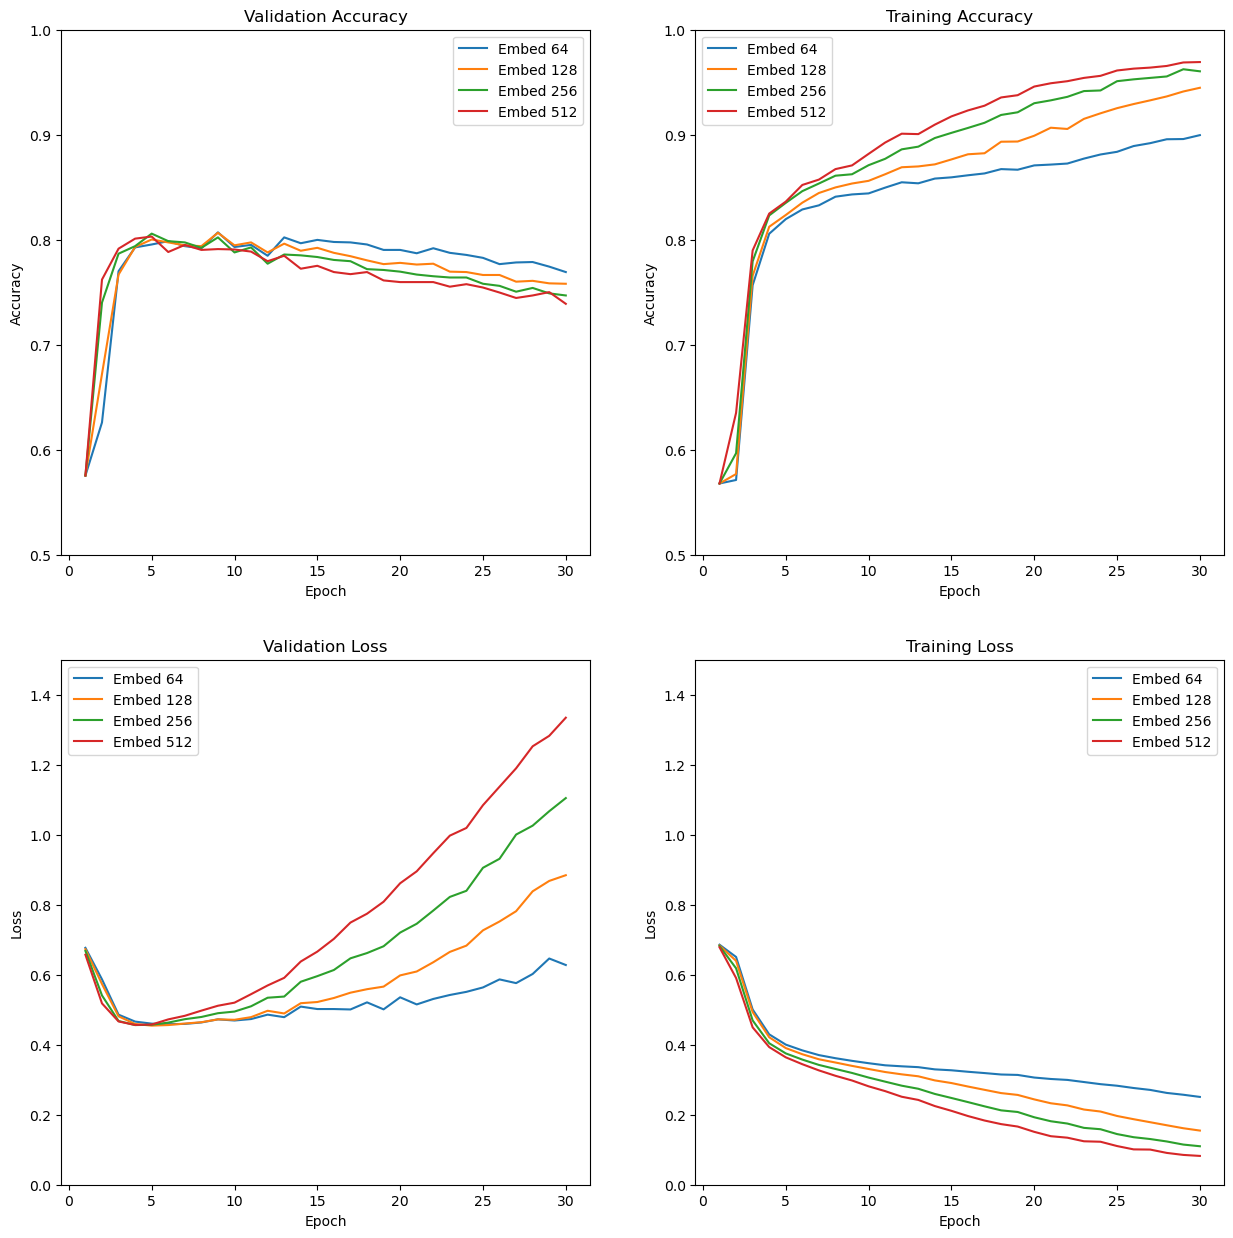

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,Embed 64,0.900,0.251,0.807,0.459,5
1,Embed 128,0.945,0.155,0.807,0.455,4
2,Embed 256,0.962,0.110,0.806,0.456,3
3,Embed 512,0.969,0.082,0.803,0.456,3


In [53]:
run3 = pd.read_pickle('run3.pickle')
plot_all_plots(run3, plot_type = 'accuracy')
plot_all_plots(run3, plot_type = 'loss')
plot_models_together(run3)
create_summary_table(run3)


## Additional GRU Layers
The next attempt I made was adding more GRU layers, to see if that would make things more accurate. 

In [54]:
# One Layers
tf.keras.backend.clear_session()
tf.random.set_seed(846)

gru_hpc_1 = Model(X_train, y_train, X_val, y_val, name ='One Layer ', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(96)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_hpc_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hpc_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 192)              130176    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               24704     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 283,009
Trainable params: 283,009
Non-trai

In [55]:
#gru_hpc_1.fit(30)

In [56]:
# Two Layers

tf.keras.backend.clear_session()
tf.random.set_seed(846)

gru_hpc_2 = Model(X_train, y_train, X_val, y_val, name ='Two Layer ', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(96, return_sequences=True)),
    layers.Bidirectional(layers.GRU(96)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_hpc_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
#gru_hpc_2.summary()



In [57]:
#Uncomment to run model
#gru_hpc_2.fit(30)

In [58]:
# Three Layers

tf.keras.backend.clear_session()
tf.random.set_seed(846)

gru_hpc_3 = Model(X_train, y_train, X_val, y_val, name ='Three Layer ', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(96, return_sequences=True)),
    layers.Bidirectional(layers.GRU(96, return_sequences=True)),
    layers.Bidirectional(layers.GRU(96)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_hpc_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hpc_3.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 192)        130176    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 192)        167040    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 192)              167040    
 nal)                                                   

In [59]:
#gru_hpc_3.fit(30)

In [60]:
#Combine all of the stats into one dictionarty and export
#run4 = gru_hpc_1.stats | gru_hpc_2.stats  | gru_hpc_3.stats 
#pickle_out('run4.pickle', run4)

## Additional Layer Conclusion
There was no apparent additional benefit from increasing the number of layers in either validation loss or accuracy, just a significant increase in runtime. I decided to continue on with one layer.

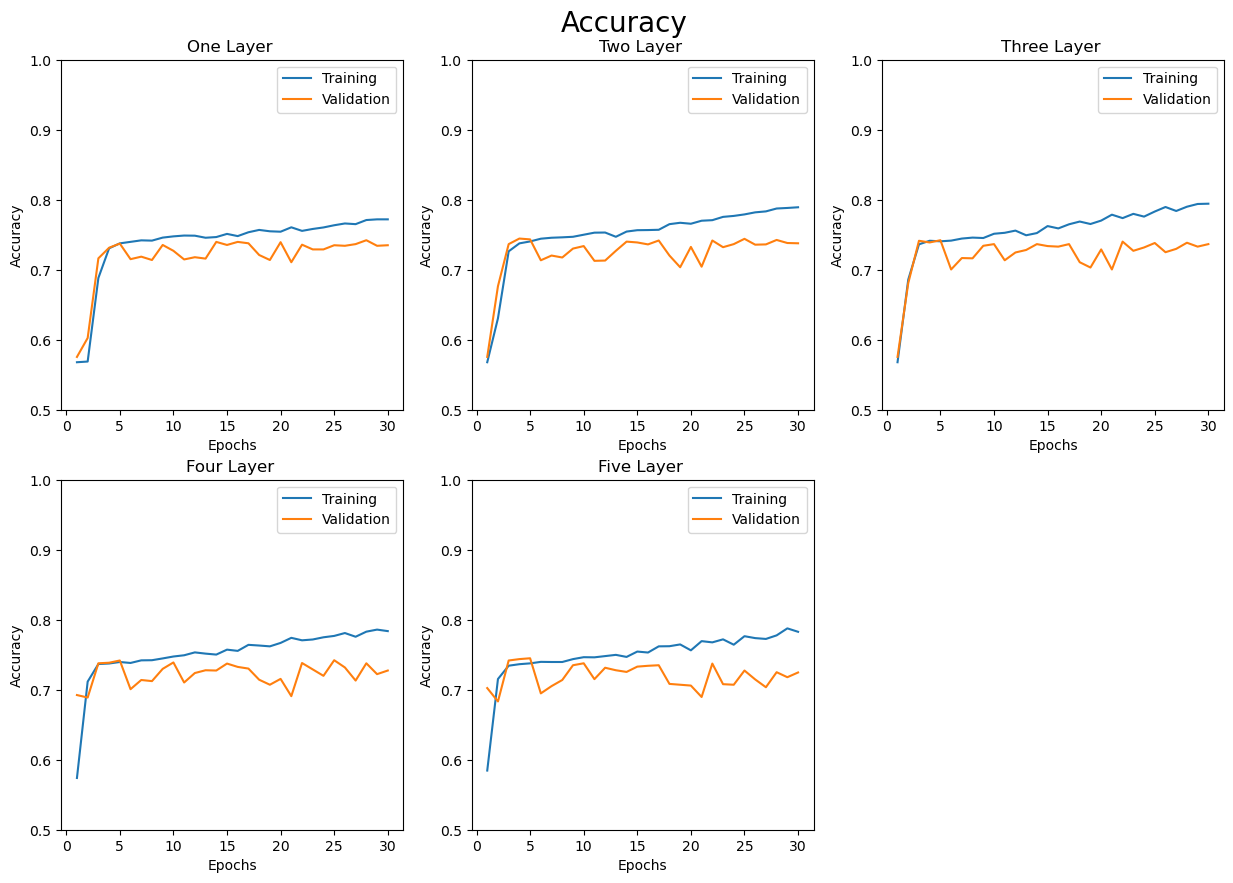

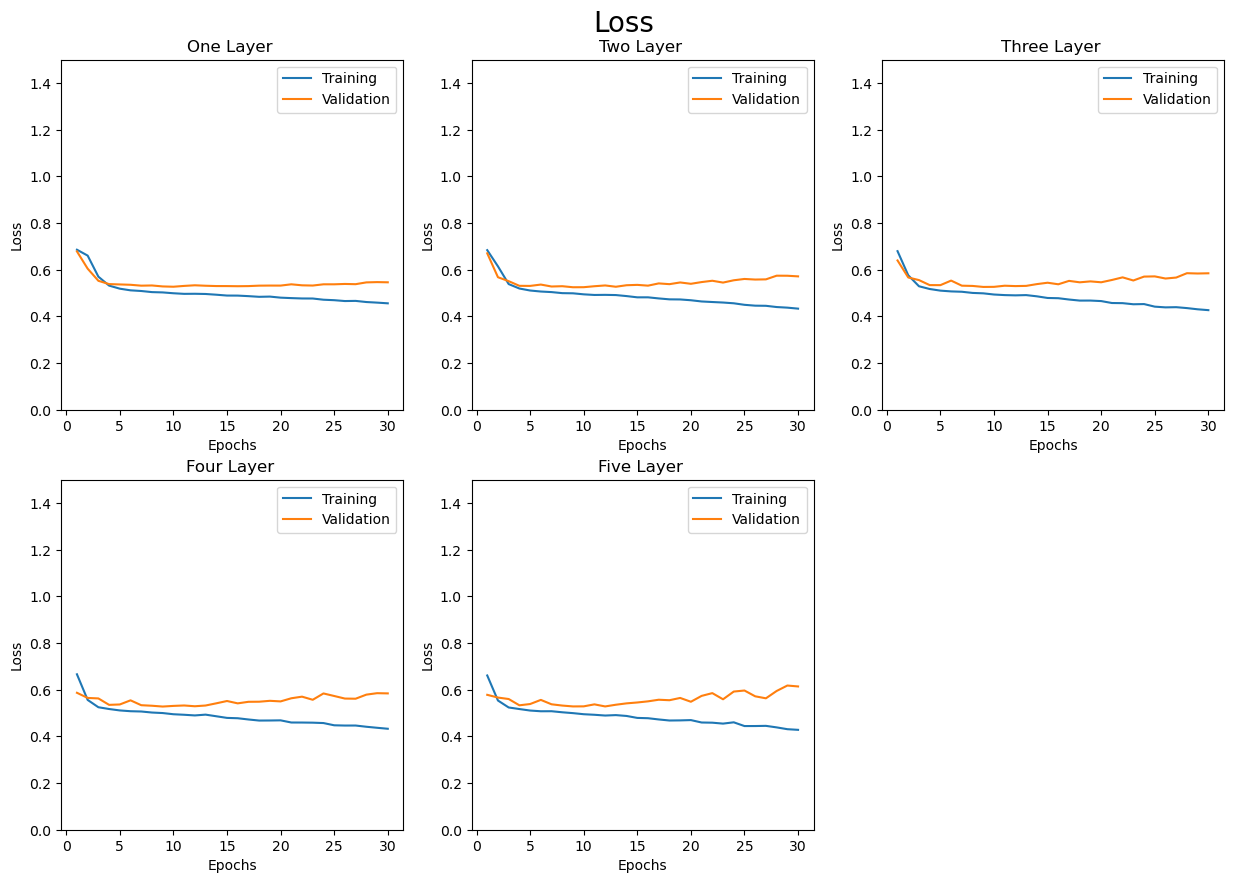

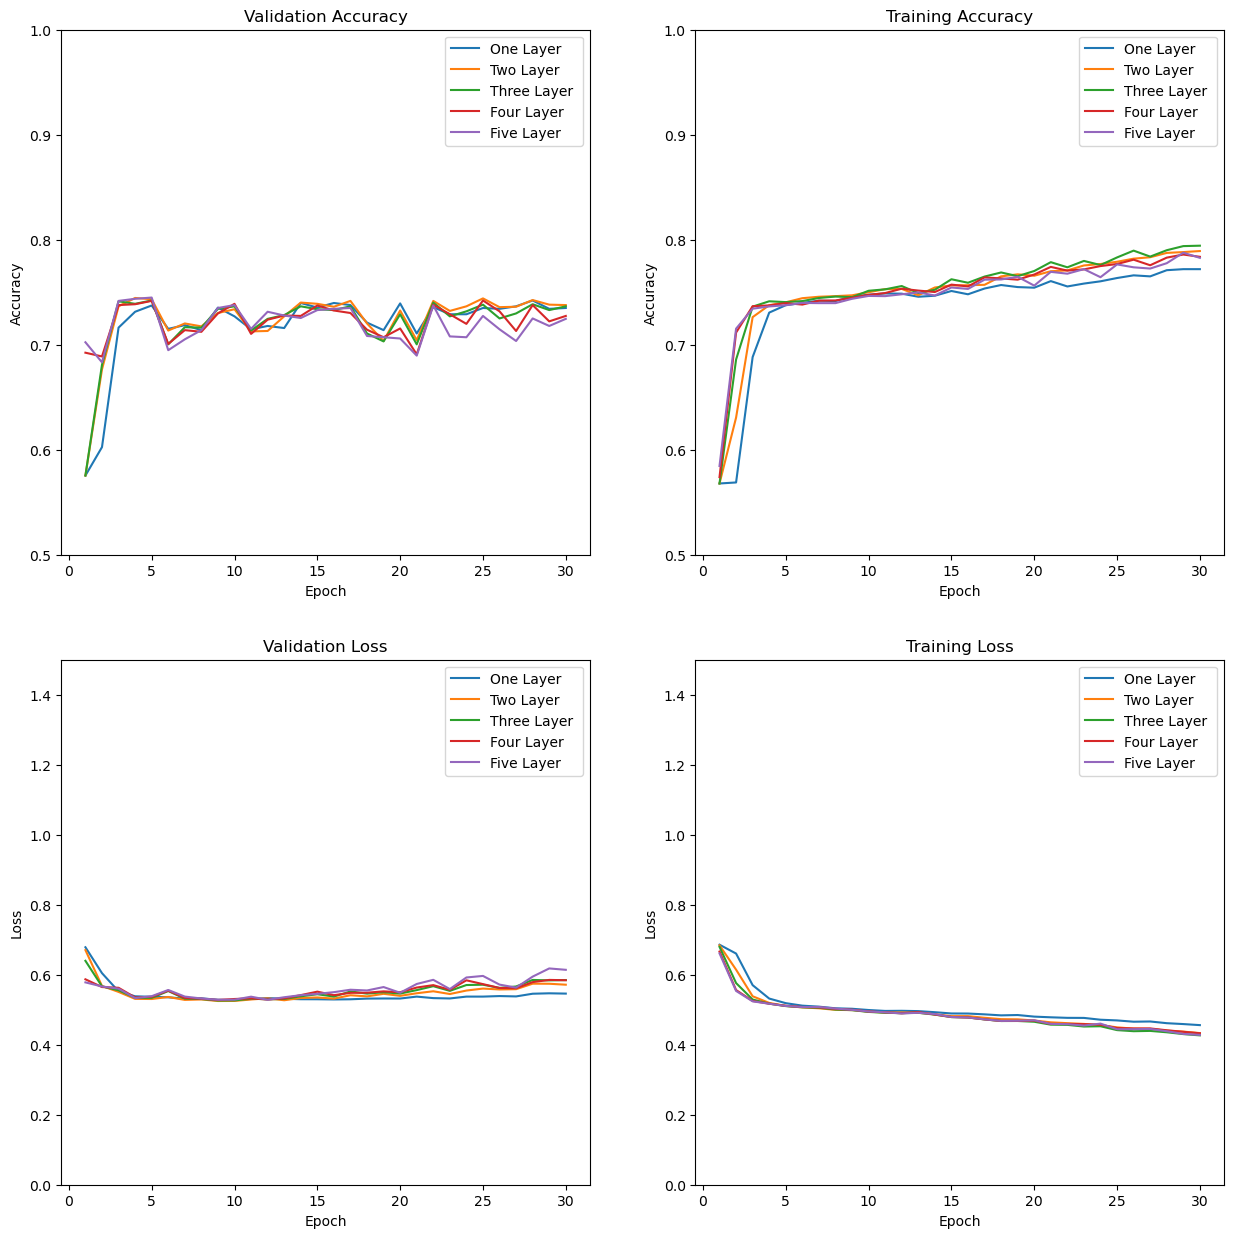

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,One Layer,0.772,0.456,0.742,0.527,9
1,Two Layer,0.789,0.433,0.745,0.525,8
2,Three Layer,0.794,0.427,0.742,0.526,8
3,Four Layer,0.786,0.433,0.742,0.528,8
4,Five Layer,0.788,0.428,0.745,0.528,11


In [61]:
run4 = pd.read_pickle('run4.pickle')
plot_all_plots(run4, plot_type = 'accuracy')
plot_all_plots(run4, plot_type = 'loss')
plot_models_together(run4)
create_summary_table(run4)

## Drop layers
My next attempt was to try adding a dropping layer. This would try and prevent some of the overfitting of the model, but randomly dropping 20 percent of each run.

In [62]:
# One Dropout Layer

tf.random.set_seed(846)

gru_hpd_1 = Model(X_train, y_train, X_val, y_val, name ='Zero Dropout Layers', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(96)),          
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_hpd_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hpd_1.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 192)              130176    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               24704     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 283,009
Trainable params: 283,009
Non-tr

In [63]:
#Uncomment to run model
#gru_hpd_1.fit(30)

In [64]:
# One Dropout Layer

tf.random.set_seed(846)

gru_hpd_2 = Model(X_train, y_train, X_val, y_val, name ='One Dropout Layer', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(96)),
    layers.Dropout(.2),              
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_hpd_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_hpd_2.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 192)              130176    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               24704     
                                                                 
 dense_5 (Dense)             (None, 1)                

In [65]:
#Uncomment to run model
#gru_hpd_2.fit(30)


In [66]:
#Combine and export stats
#pickle_out('run5.pickle', gru_hpd_1.stats | gru_hpd_2.stats)

## Dropped layer conclusion
There was no increase in accuracy or improvment in loss by dropping layers. Therefore, I will not drop any layers as we contine forward with the testing process.

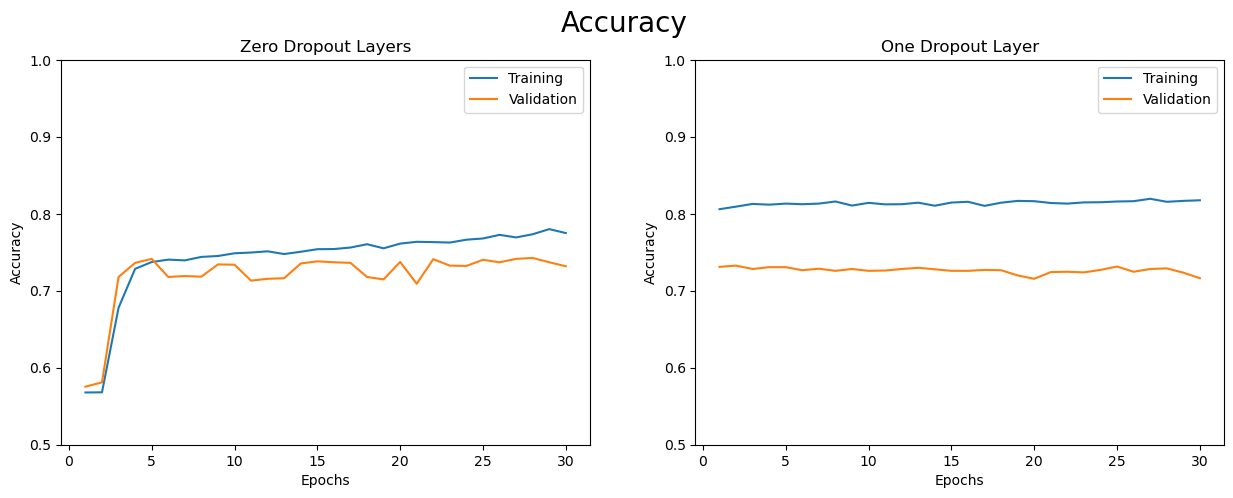

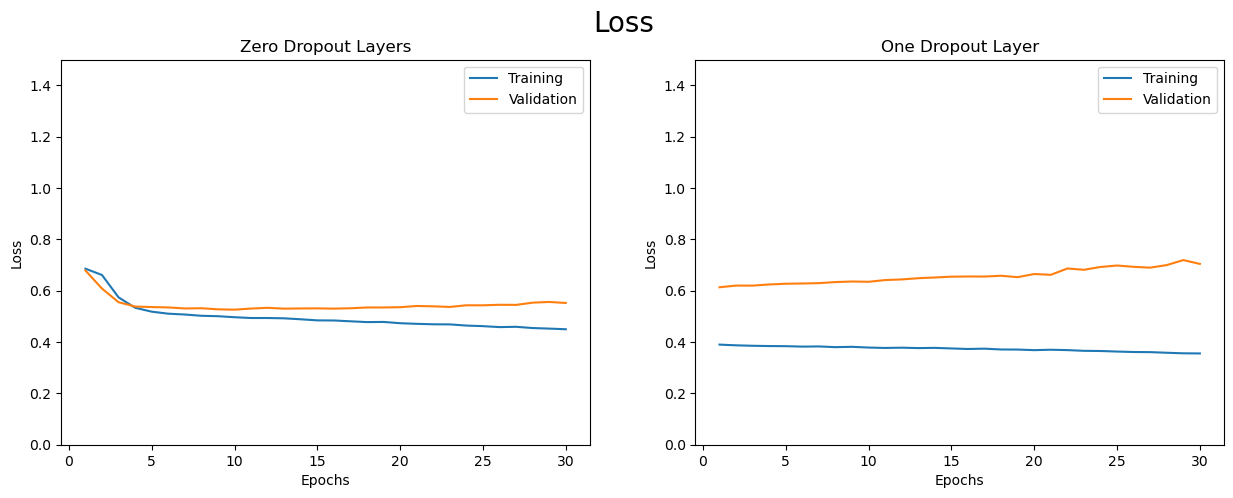

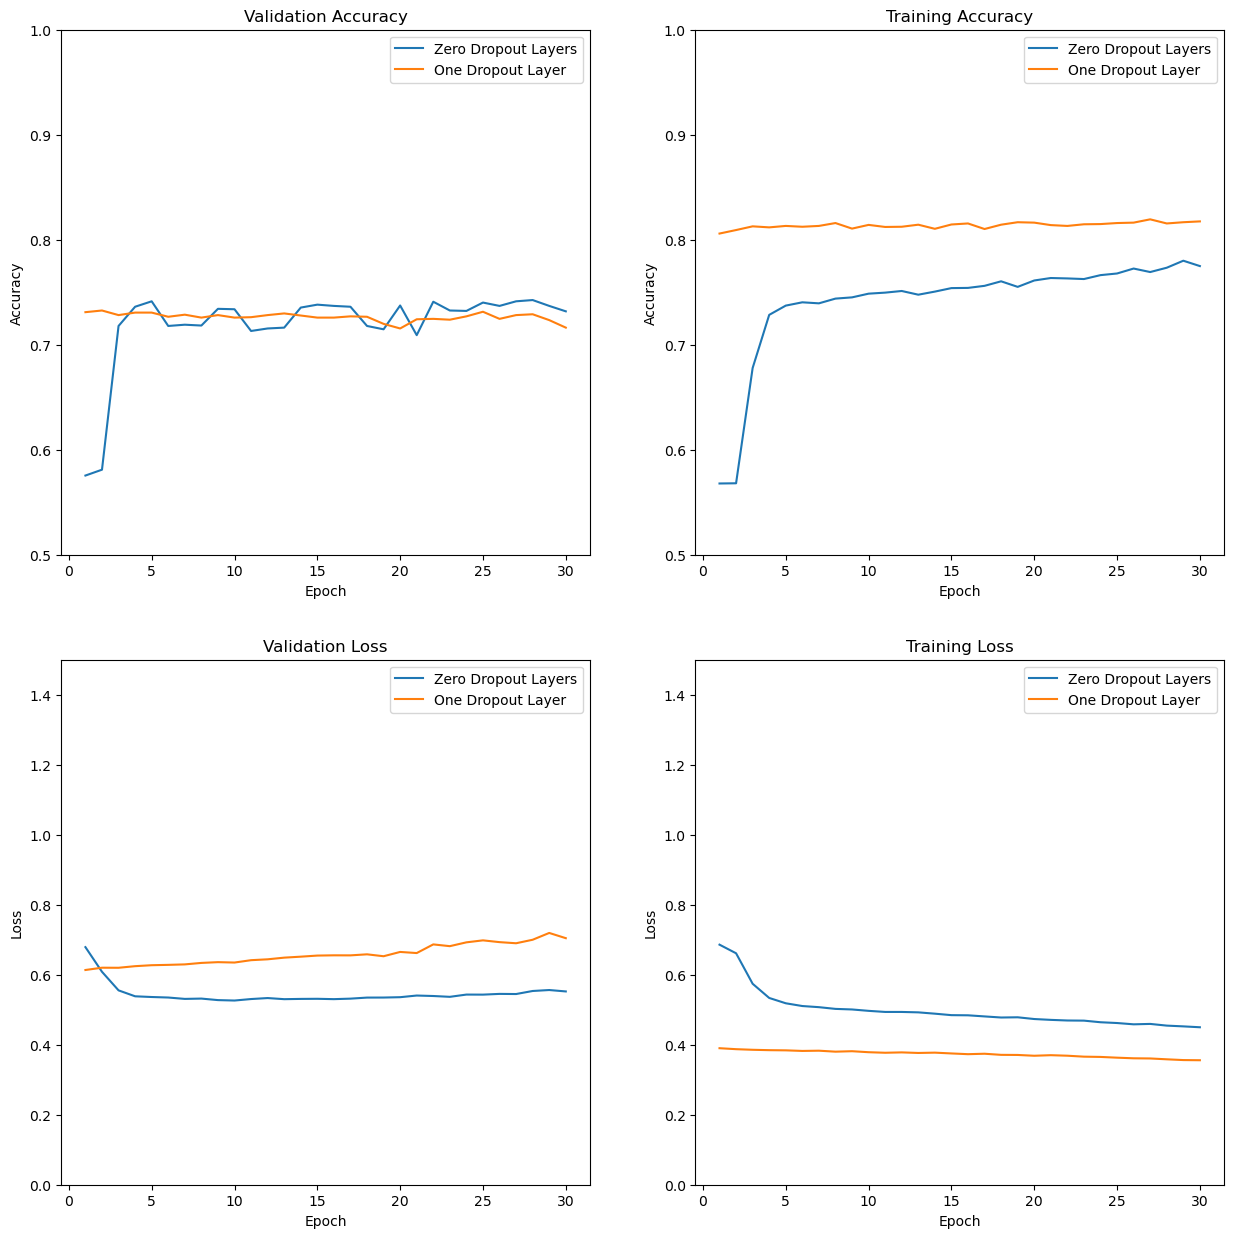

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,Zero Dropout Layers,0.780,0.450,0.743,0.526,9
1,One Dropout Layer,0.819,0.356,0.733,0.613,0


In [67]:
run5 = pd.read_pickle('run5.pickle')
plot_all_plots(run5, plot_type = 'accuracy')
plot_all_plots(run5, plot_type = 'loss')
plot_models_together(run5)
create_summary_table(run5)

## Data Augmentation
As I had referenced in the preporcessing section,I  augmented the data to see if that would improve the model. I also added LSTM comparison model with data augmentation to see if the type of model made any more difference with the addition of more data. 

In [68]:
# Non=Augmented
tf.random.set_seed(846)

gru_aug_1 = Model(X_train, y_train, X_val, y_val, name ='Non-Augmented', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(96)),        
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_aug_1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_aug_1.summary()




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 192)              130176    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               24704     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 283,009
Trainable params: 283,009
Non-tr

In [69]:
# Uncomment to run model
#gru_aug_1.fit(30)

In [70]:
# Augmented
tf.random.set_seed(846)

gru_aug_2 = Model(X_train, y_train, X_val, y_val, name ='Augmented', 
    model = Sequential([encoder_aug,
    layers.Embedding(
        input_dim=word_count_aug,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(96)),        
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_aug_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_aug_2.summary()




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 192)              130176    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               24704     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 283,009
Trainable params: 283,009
Non-tr

In [71]:
# Uncomment to run model
#gru_aug_2.fit(30)

In [72]:
# Non Augmented LSTM
tf.random.set_seed(846)

gru_aug_3 = Model(X_train, y_train, X_val, y_val, name ='Non-Augmented- LTSM', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),        
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_aug_3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_aug_3.summary()




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 243,457
Trainable params: 243,457
Non-tr

In [73]:
# Uncomment to run model
#gru_aug_3.fit(30)

In [74]:
# Augmented
tf.random.set_seed(846)

gru_aug_4 = Model(X_train, y_train, X_val, y_val, name ='Augmented- LTSM', 
    model = Sequential([encoder_aug,
    layers.Embedding(
        input_dim=word_count_aug,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),        
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )
gru_aug_4.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
gru_aug_4.summary()




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, None, 128)         128000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 243,457
Trainable params: 243,457
Non-tr

In [75]:
# Uncomment to run model
#gru_aug_4.fit(30)

In [76]:
#run6 = gru_aug_1.stats | gru_aug_2.stats | gru_aug_3.stats | gru_aug_4.stats
#pickle_out('run6.pickle', run6)

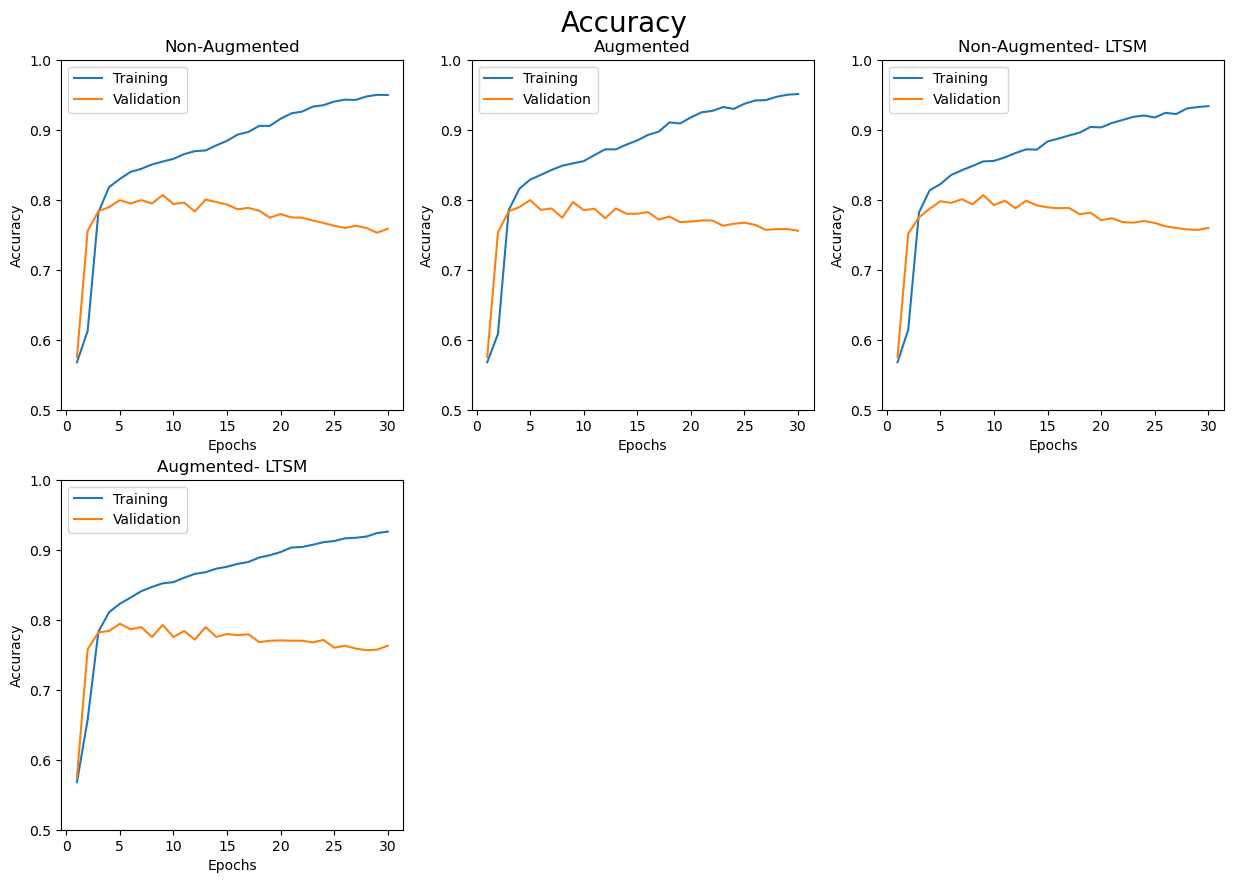

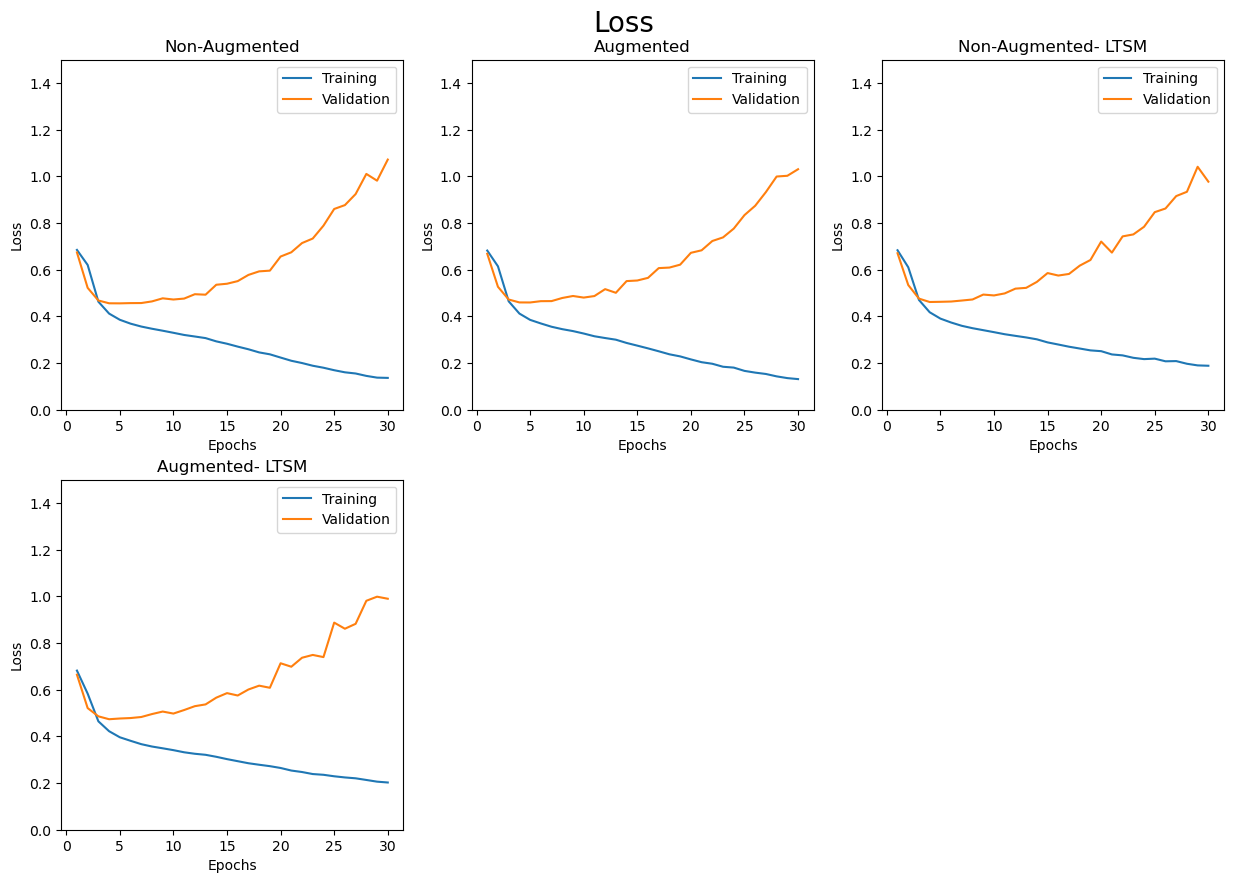

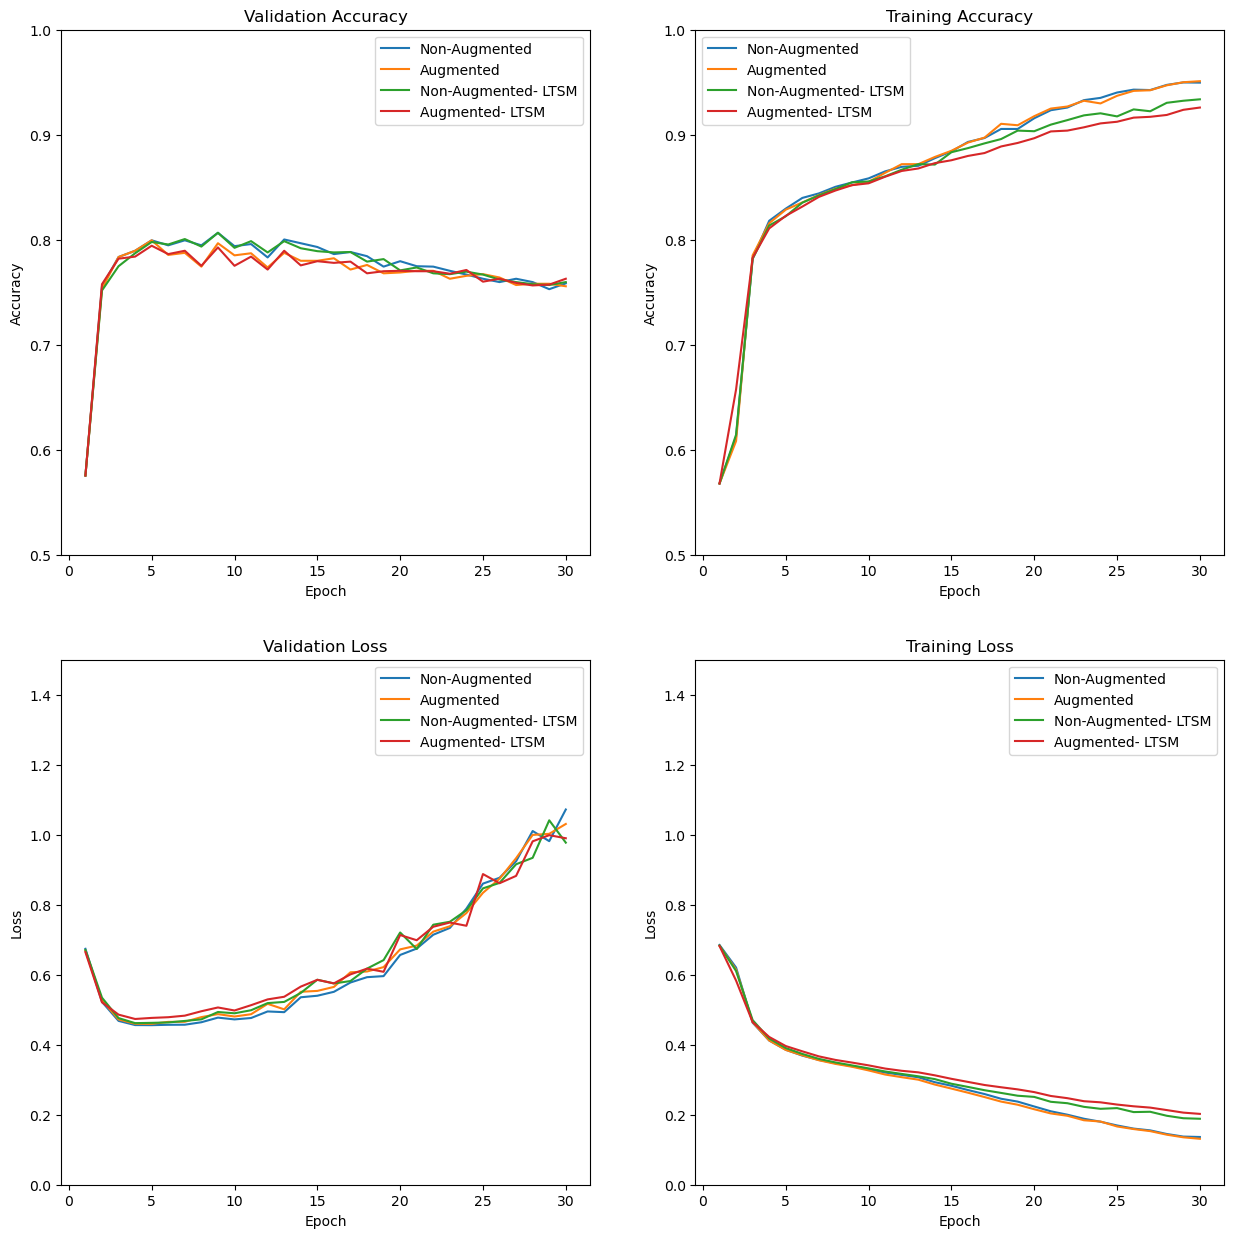

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,Non-Augmented,0.950,0.136,0.807,0.456,4
1,Augmented,0.951,0.131,0.799,0.460,4
2,Non-Augmented- LTSM,0.934,0.188,0.807,0.462,3
3,Augmented- LTSM,0.926,0.202,0.794,0.474,3


In [77]:
run6 = pd.read_pickle('run6.pickle')
plot_all_plots(run6, plot_type = 'accuracy')
plot_all_plots(run6, plot_type = 'loss')
plot_models_together(run6)
create_summary_table(run6)

## Final Model
For the final model, I ended up going with the GRU model that I initially ran. It had the best validation loss  and accuracy. For the final predictions, I didn’t want to have a model that was overfitted, so I only ran the final model for 5 epochs, and then made plots with loss and accuracy to make sure I didn’t have an inflection point where we started to overfit.

In the end, I had a Kaggle accuracy of 0.78547.

In [78]:
create_summary_table(run1| run2 | run3 | run4 | run5 | run6)

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,RNN without Bidirectional,0.979,0.054,0.790,0.482,3
1,RNN with Bidirectional,0.983,0.044,0.795,0.470,4
2,LTSM without Bidirectional,0.926,0.214,0.802,0.464,3
3,LTSM with Bidirectional,0.929,0.176,0.803,0.463,3
4,GRU without Bidirectional,0.903,0.252,0.800,0.462,5
5,GRU with Bidirectional,0.946,0.162,0.803,0.458,5
6,Gru 64,0.939,0.173,0.807,0.454,4
7,Gru 128,0.947,0.138,0.803,0.459,3
8,Gru 256,0.957,0.106,0.803,0.454,3
9,Embed 64,0.900,0.251,0.807,0.459,5


In [79]:
# Final Model
tf.keras.backend.clear_session()
tf.random.set_seed(846)
final_model = Model(X_train, y_train, X_val, y_val, name ='Final', 
    model = Sequential([encoder,
    layers.Embedding(
        input_dim=word_count,
        output_dim=128,
        mask_zero=True),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)])
    )

final_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate =.0001,),
              metrics=['accuracy'])
final_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 219,137
Trainable params: 219,137
Non-trai

In [97]:
final_model.fit(5)
#pickle_out('final.pickle', final_model.stats)


Epoch 1/5
160/160 [==============================] - 18s 54ms/step - loss: 0.6840 - accuracy: 0.5678 - val_loss: 0.6736 - val_accuracy: 0.5754
Epoch 2/5
160/160 [==============================] - 6s 36ms/step - loss: 0.6422 - accuracy: 0.5749 - val_loss: 0.5807 - val_accuracy: 0.6566
Epoch 3/5
160/160 [==============================] - 6s 35ms/step - loss: 0.4956 - accuracy: 0.7567 - val_loss: 0.4761 - val_accuracy: 0.7839
Epoch 4/5
160/160 [==============================] - 6s 36ms/step - loss: 0.4184 - accuracy: 0.8090 - val_loss: 0.4562 - val_accuracy: 0.7931
Epoch 5/5
160/160 [==============================] - 6s 37ms/step - loss: 0.3880 - accuracy: 0.8249 - val_loss: 0.4531 - val_accuracy: 0.7986


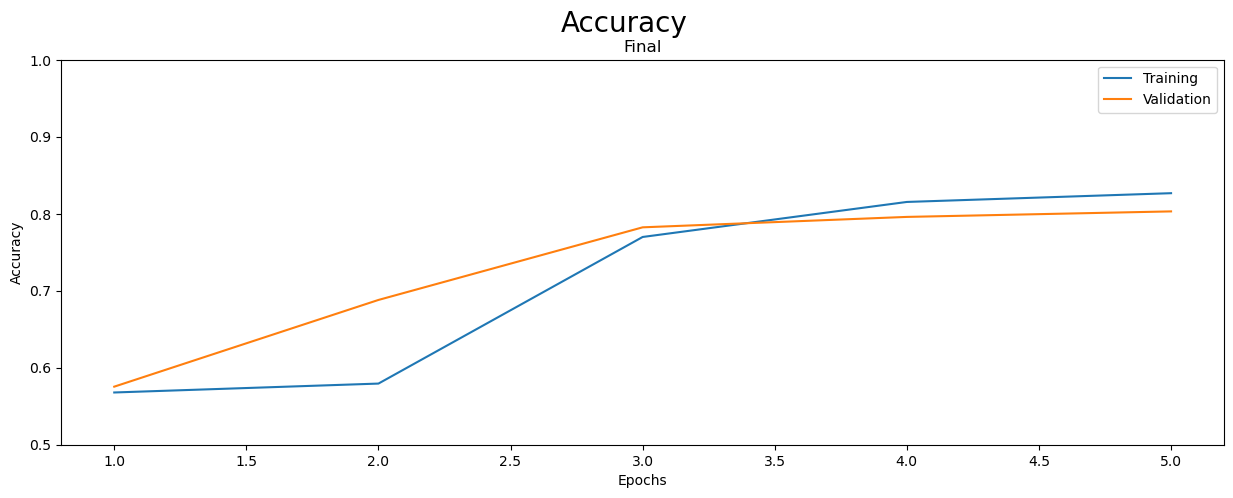

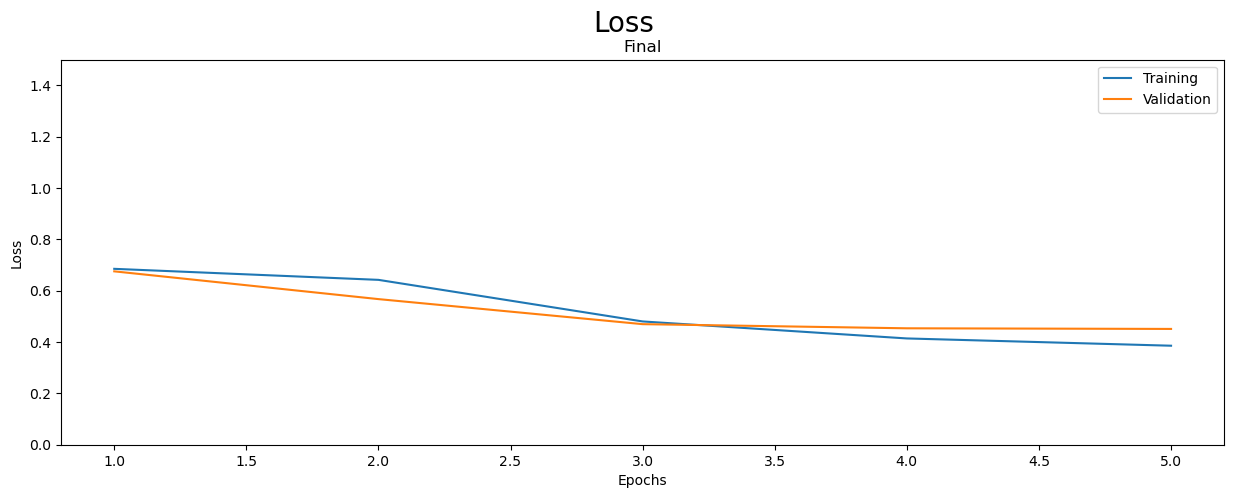

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,Final,0.827,0.386,0.803,0.451,4


In [81]:
final = pd.read_pickle('final.pickle')
plot_all_plots(final, plot_type = 'accuracy')
plot_all_plots(final, plot_type = 'loss')
create_summary_table(final)

In [98]:
kaggle_pred = final_model.predict(test['text'])

102/102 [==============================] - 1s 9ms/step


In [99]:
# Create a submission for Kaggle

sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission = sample_submission.copy()
submission['target'] = (kaggle_pred)
submission.to_csv('kaggle_predictions1.csv', index = False)


# Conclusion
I admit that I am a little surprised by the results of my tuning. All of the the tuning I did resulted in models that had the same accuracy and loss, or worse. I think the next thing that I would try would be to change how the text is vectorized. If I continued the tuning of the model, would use TF-IDF and see if it would improve the accuracy. I could also try and do more tuning with LSTM model to see if that would make a difference over the GRU.

As to the actual model itself, it didn’t do awful, but there was certainly room for improvement. In looking at the confusion matrix, it had more false negatives, as opposed to false positives. It depends on what you want to use the model for whether you would want it to err on the side of false positives or false negatives. If you want to make sure that you are always categorizing something as a disaster, even when it is not, this is not where you want your model to be. However, if you really don’t want to label something as a disaster, unless it fore sure is, this model is in a better place. 

 Also, as was previously mentioned, I am not completely sure that the data being trained on is 100 percent accurate. Therefore, the entire usefulness of the model is called into question on those  grounds. If I actually wanted to use this model in any sort of production setting, I would want to do more research in that area. 

In [100]:
# Create a confusion matrix

val_pred = final_model.predict(X_val)

79/79 [==============================] - 1s 9ms/step


In [101]:
# Calculate F1 score
print(f"F1 score: {f1_score(y_val, val_pred): .4f}")

F1 score:  0.7506


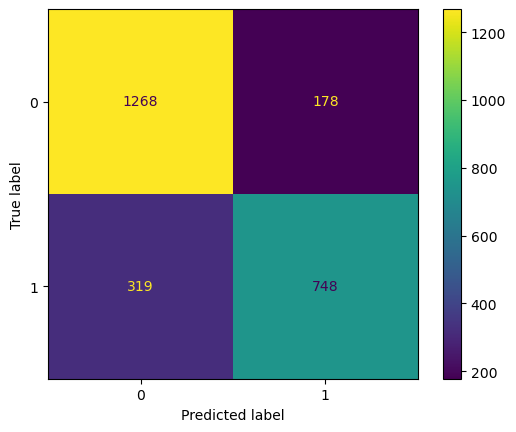

In [102]:
cm = confusion_matrix(y_val, val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.title = 'Test'
plt.show()

# Reference
Chablani, Manish. "RNN Training Tips and Tricks:RNN Training Tips and Tricks." Towards Data Science. June 13, 2017.  https://towardsdatascience.com/rnn-training-tips-and-tricks-2bf687e67527

Figure-Eight. Kaggle. https://www.kaggle.com/competitions/nlp-getting-started/overview/description

Hamdaoui, Yassine. "TF(Term Frequency)-IDF(Inverse Document Frequency) from scratch in python." Towards Data Science. Decmber 9th, 2019. https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558

Phi, Michael. "Illustrated Guide to LSTM’s and GRU’s: A step by step explanationIllustrated Guide to LSTM’s and GRU’s: A step by step explanation." Towards Data Science. September 24, 2018. https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

